In [70]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, MaxPooling1D, UpSampling1D, Dropout, BatchNormalization, concatenate

In [91]:
def Model():

    def down_block(x, filters):
        x = Conv1D(filters, 3, padding="same", activation=tf.nn.relu, kernel_initializer='he_normal')(x)
        x = Conv1D(filters, 3, padding="same", activation=tf.nn.relu, kernel_initializer='he_normal')(x)
        x = BatchNormalization(axis=-1, momentum=0.95, epsilon=0.001)(x)
        #x = Dropout(rate=0.0)(x)
        return x

    def max_pool(x):
        return MaxPooling1D(padding="same", strides=2, pool_size=2)(x)

    def up_block(x, filters, skip_connect):
        # x = UpSampling1D(size = 2)(x)
        x = Conv1DTranspose(filters, 3, strides=2, padding="same", activation=tf.nn.relu)(x)
        x = concatenate([x, skip_connect], axis=2)
        x = Conv1D(filters, 3, padding="same", activation=tf.nn.relu, kernel_initializer='he_normal')(x)
        x = Conv1D(filters, 3, padding="same", activation=tf.nn.relu, kernel_initializer='he_normal')(x)
        x = BatchNormalization(axis=-1, momentum=0.95, epsilon=0.001)(x)
        #x = Dropout(rate=0.0)(x)
        return x 

    def unet():
        fn = [42, 84, 168, 336]
        fdepth = len(fn)

        x_stack = []
        xin = keras.Input(shape=(HEIGHT, WIDTH), name='img')

        x = xin
        for idx in range(fdepth):
            x = down_block(x, fn[idx])

            if(idx < fdepth - 1):
                x_stack.append(x)
                x = max_pool(x)

        for idx in range(fdepth - 1):
            idx = fdepth - idx - 2
            x = up_block(x, fn[idx], x_stack.pop())

        xout = Conv1D(NUM_OUTPUTS, 1, padding="same", activation='linear')(x)
        return tf.keras.Model(inputs=xin, outputs=xout)

    return unet()

In [92]:
# Network Parameters
WIDTH = 168
HEIGHT = 40
NUM_OUTPUTS = 28

In [93]:
# Setup Unet model
model = Model()
model.summary()

Model: "functional_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 40, 168)]    0                                            
__________________________________________________________________________________________________
conv1d_284 (Conv1D)             (None, 40, 42)       21210       img[0][0]                        
__________________________________________________________________________________________________
conv1d_285 (Conv1D)             (None, 40, 42)       5334        conv1d_284[0][0]                 
__________________________________________________________________________________________________
batch_normalization_144 (BatchN (None, 40, 42)       168         conv1d_285[0][0]                 
______________________________________________________________________________________

In [94]:
# Load bSSFP images training data and ground truth 
img_data = np.load('c:\\Users\\yiten\\Documents\\MRI Relaxometry\\img_reg_data\\img_data.npy')
gt_data = np.load('c:\\Users\\yiten\\Documents\\MRI Relaxometry\\img_reg_data\\gt_img_data.npy')

img_data = (img_data - np.min(img_data))/(np.max(img_data) - np.min(img_data))
gt_data = (gt_data - np.min(gt_data))/(np.max(gt_data) - np.min(gt_data))

# Train test split
img_train, img_test, gt_train, gt_test = train_test_split(img_data, gt_data, test_size=0.1, random_state=42)

In [95]:
# Set optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Train the network
model.compile(optimizer=opt, loss='mse', metrics='mse')
start=time.time()
history = model.fit(img_train, gt_train, epochs=30, batch_size=10, validation_split=0.1)  
end=time.time()
print('Time Elapsed:%i seconds'%(end-start))

Epoch 1/30
81/81 [==============================] - 4s 45ms/step - loss: 0.2723 - mse: 0.2723 - val_loss: 0.0681 - val_mse: 0.0681
Epoch 2/30
81/81 [==============================] - 2s 26ms/step - loss: 0.0262 - mse: 0.0262 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 3/30
81/81 [==============================] - 2s 25ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 4/30
81/81 [==============================] - 2s 23ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 5/30
81/81 [==============================] - 2s 26ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 6/30
81/81 [==============================] - 2s 29ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 7/30
81/81 [==============================] - 2s 28ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 8/30
81/81 [==============================] - 2s 28ms/step - loss: 9.5509e-04

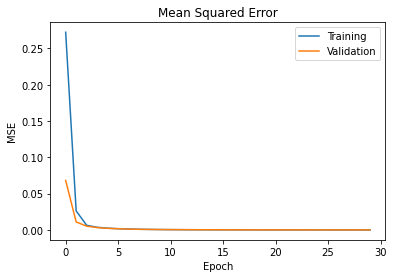

10/10 [==============================] - 0s 12ms/step - loss: 8.2244e-05 - mse: 8.2244e-05
Test MSE:0.000082


In [96]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Evaluate model using testing set
test_metric = model.evaluate(img_test, gt_test, batch_size=10)
print('Test MSE:%.6f'%test_metric[1])

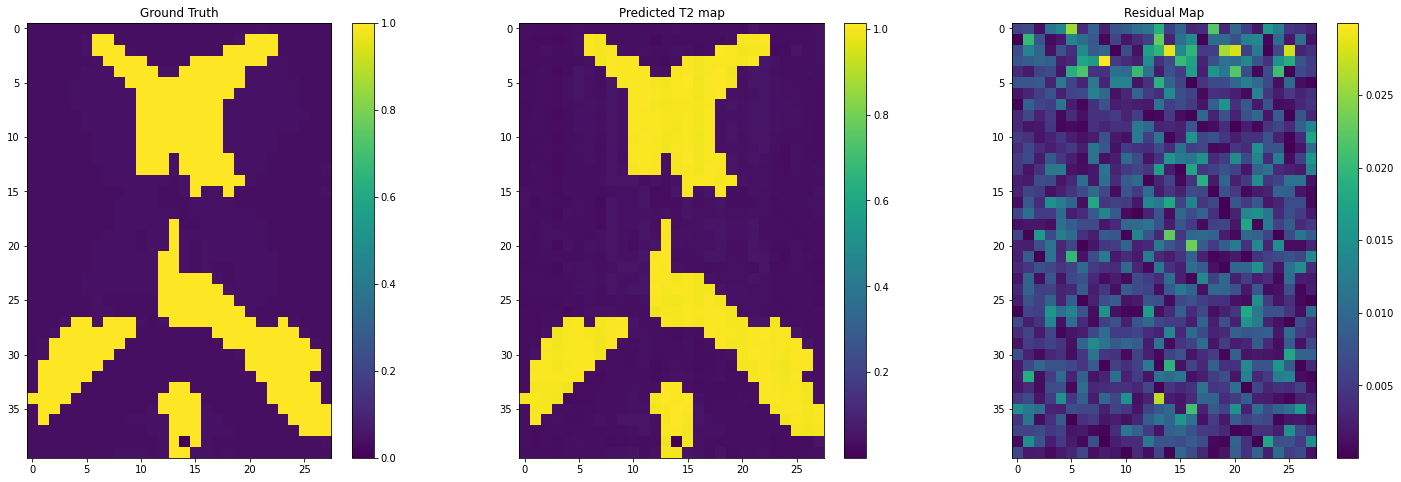

In [105]:
predicted_t2map = model.predict(img_test)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 8))
im = ax1.imshow(gt_test[0])
ax1.set_title('Ground Truth')
plt.colorbar(im,ax=ax1)

im = ax2.imshow(predicted_t2map.mean(axis=0))
ax2.set_title('Predicted T2 map')
plt.colorbar(im,ax=ax2)

residual_map = abs(gt_test[0]-predicted_t2map[0])
im = ax3.imshow(residual_map)
ax3.set_title('Residual Map')
plt.colorbar(im,ax=ax3)

In [ ]:
# Define the network structure
inputs = tf.keras.Input(shape = (img_data.shape[1],img_data.shape[2]))

conv1 = tf.keras.layers.Conv1D(112, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(inputs)
conv1 = tf.keras.layers.Conv1D(112, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv1)
pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv1)

conv2 = tf.keras.layers.Conv1D(56, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(pool1)
conv2 = tf.keras.layers.Conv1D(56, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv2)
drop2 = tf.keras.layers.Dropout(0.5)(conv2)
pool2 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop2)

conv3 = tf.keras.layers.Conv1D(14, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(pool2)
conv3 = tf.keras.layers.Conv1D(14, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv3)
drop3 = tf.keras.layers.Dropout(0.5)(conv3)

up4 = tf.keras.layers.UpSampling1D(size = 2)(conv3)
deconv4 = tf.keras.layers.Conv1DTranspose(28, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(up4)

up5 = tf.keras.layers.UpSampling1D(size = 2)(deconv4)
deconv5 = tf.keras.layers.Conv1DTranspose(28, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(up5)

model = tf.keras.Model(inputs = inputs, outputs = deconv5)

print(model.summary())